In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50) ## to display more rows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-454'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key_train = 'Project_1/dmc2010_train.txt'
file_key_test = 'Project_1/dmc2010_class.txt'

bucket_object_train = bucket.Object(file_key_train)
file_object_train = bucket_object_train.get()
file_content_stream_train = file_object_train.get('Body')

bucket_object_test = bucket.Object(file_key_test)
file_object_test = bucket_object_test.get()
file_content_stream_test = file_object_test.get('Body')

## Reading train file
train = pd.read_csv(file_content_stream_train, sep = ';')
train.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
0,41191,2008-12-01,0,0,9,2008-12-01,0,2,2,0,58,NaN,1,NaN,2,2,0,1,0,0,2008-12-03,2008-12-02,737,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,38860,2008-12-16,1,0,4,2008-12-16,0,1,1,1,34,NaN,0,NaN,2,2,0,0,0,0,2008-12-30,2009-02-03,368,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2,61917,2008-08-19,0,0,12,2008-08-19,0,1,0,0,51,NaN,0,NaN,1,1,0,0,0,1,2008-09-02,2008-08-28,47,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,40647,2008-06-16,1,0,8,2008-06-16,0,1,0,0,25,NaN,0,NaN,3,2,0,0,0,0,2008-06-17,0000-00-00,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
4,1347,2008-08-08,0,0,1,2008-08-08,0,1,1,1,41,NaN,0,BR,4,2,0,0,0,0,2008-08-11,2008-08-08,843,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0


## Females

In [2]:
females = train[train['salutation'] == 0]
females.head()

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
0,41191,2008-12-01,0,0,9,2008-12-01,0,2,2,0,58,NaN,1,NaN,2,2,0,1,0,0,2008-12-03,2008-12-02,737,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,61917,2008-08-19,0,0,12,2008-08-19,0,1,0,0,51,NaN,0,NaN,1,1,0,0,0,1,2008-09-02,2008-08-28,47,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1347,2008-08-08,0,0,1,2008-08-08,0,1,1,1,41,NaN,0,BR,4,2,0,0,0,0,2008-08-11,2008-08-08,843,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
5,4686,2008-08-10,0,0,12,2008-08-10,0,1,0,0,95,NaN,0,BQ,3,3,0,0,0,1,2008-08-12,2008-08-11,1218,0,0,3,1,2,0,0,0,0,0,0,0,0,0,0
6,28710,2008-12-21,0,0,12,2008-12-21,0,3,1,1,78,NaN,0,NaN,4,1,0,1,0,0,2008-12-23,2008-12-22,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [5]:
females['target90'].value_counts() / females.shape[0]

0    0.80667
1    0.19333
Name: target90, dtype: float64

In [6]:
females.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,17840.000000,17840.0,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.00000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.0,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.00000
mean,33345.275336,0.0,0.003027,7.253419,0.189406,1.707567,0.855774,0.219955,48.45370,0.166031,2.919451,2.167040,0.004092,0.458240,0.0,0.151794,698.931558,0.065807,0.060202,0.079204,0.932231,0.465247,0.320740,0.012444,0.045067,0.153419,0.023991,0.023374,0.000112,0.173487,0.103587,0.19333
std,19093.143097,0.0,0.054936,3.611969,0.391842,0.836126,1.023243,0.414228,24.08597,0.372119,1.304935,1.796974,0.063839,0.498267,0.0,0.358831,736.303742,0.426486,0.299049,0.508082,1.481259,1.458287,1.282391,0.176740,0.308499,0.527462,0.209871,0.304980,0.010588,0.866569,0.559512,0.39492
min,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,16856.500000,0.0,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,30.00000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,145.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,33470.500000,0.0,0.000000,8.000000,0.000000,1.000000,0.000000,0.000000,47.00000,0.000000,3.000000,2.000000,0.000000,0.000000,0.0,0.000000,560.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,49850.250000,0.0,0.000000,9.000000,0.000000,2.000000,2.000000,0.000000,65.00000,0.000000,4.000000,3.000000,0.000000,1.000000,0.0,0.000000,978.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,66251.000000,0.0,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.00000,1.000000,5.000000,30.000000,1.000000,1.000000,0.0,1.000000,10690.000000,19.000000,8.000000,19.000000,43.000000,84.000000,56.000000,8.000000,8.000000,14.000000,11.000000,25.000000,1.000000,48.000000,27.000000,1.00000


In [216]:
pd.crosstab(females['invoicepostcode'], females['target90'])

target90,0,1
invoicepostcode,,
1,124,23
2,17,8
3,46,17
4,113,18
6,122,21
...,...,...
95,54,12
96,111,24
97,126,26


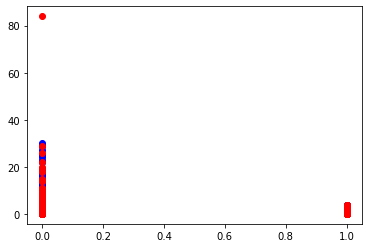

In [218]:
Color = ['blue', 'red']
for i in females['target90'].unique():
    temp = females[females['target90'] == i]
    plt.scatter(temp['shippingcosts'], temp['w1'], color = Color[i])

In [214]:
pd.crosstab(females['w3'], females['target90'])

target90,0,1
w3,,
0,14293,3402
1,76,34
2,14,3
3,6,2
4,1,3
5,0,1
6,1,2
7,0,1
8,0,1


In [139]:
2973 / (2973 + 11905)

0.1998252453286732

In [140]:
476 / (476 + 2486)

0.16070222822417285

In [9]:
females['model'].value_counts() / females.shape[0]

1    0.538509
3    0.246076
2    0.215415
Name: model, dtype: float64

In [119]:
x = females[(females['w2'] > 0)]
# x = females[(females['model'] == 1) & (females['w0'] > 3)]
x['target90'].value_counts() / x.shape[0]

0    0.784247
1    0.215753
Name: target90, dtype: float64

In [118]:
x.shape

(1225, 38)

## Males

In [48]:
males = train[train['salutation'] == 1]
males.head()

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
1,38860,2008-12-16,1,0,4,2008-12-16,0,1,1,1,34,NaN,0,NaN,2,2,0,0,0,0,2008-12-30,2009-02-03,368,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40647,2008-06-16,1,0,8,2008-06-16,0,1,0,0,25,NaN,0,NaN,3,2,0,0,0,0,2008-06-17,0000-00-00,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
10,6422,2008-12-20,1,0,9,2008-12-20,0,2,0,0,58,NaN,0,NaN,5,3,0,1,0,0,2008-12-23,2008-12-22,1703,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
13,12934,2008-05-06,1,0,6,2008-05-06,0,2,0,0,40,NaN,0,BQ,4,2,0,1,0,0,2008-05-08,2008-05-07,926,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
17,44942,2008-12-20,1,0,12,2008-12-20,0,1,3,0,88,NaN,0,NaN,3,1,0,0,0,0,2008-12-23,2008-12-21,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [49]:
males['target90'].value_counts() / males.shape[0]

0    0.814018
1    0.185982
Name: target90, dtype: float64

In [11]:
males['model'].value_counts() / males.shape[0]

1    0.631221
3    0.197004
2    0.171775
Name: model, dtype: float64

In [46]:
males.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,11614.000000,11614.0,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.0,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000
mean,33480.540641,1.0,0.014035,7.546754,0.149216,1.565783,1.234545,0.185724,49.146031,0.174100,2.847942,1.827536,0.005080,0.361288,0.0,0.148011,547.577407,0.048734,0.060961,0.056570,0.785517,0.312037,0.219907,0.030050,0.045721,0.241347,0.033408,0.018684,0.000258,0.146031,0.075857,0.185982
std,19237.925903,0.0,0.117639,3.703305,0.356317,0.799834,1.143802,0.388901,24.557028,0.379212,1.327058,1.580623,0.071096,0.480395,0.0,0.355126,681.381182,0.324708,0.311501,0.402976,1.705642,1.036955,1.462713,0.345034,0.400714,0.626251,0.402677,0.187655,0.016071,0.697533,0.610210,0.389109
min,6.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16664.000000,1.0,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,30.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33576.000000,1.0,0.000000,8.000000,0.000000,1.000000,1.000000,0.000000,48.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0,0.000000,396.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,50303.750000,1.0,0.000000,12.000000,0.000000,2.000000,2.000000,0.000000,67.000000,0.000000,4.000000,2.000000,0.000000,1.000000,0.0,0.000000,830.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,66245.000000,1.0,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,50.000000,1.000000,1.000000,0.0,1.000000,20076.000000,12.000000,17.000000,13.000000,99.000000,25.000000,90.000000,15.000000,26.000000,7.000000,27.000000,6.000000,1.000000,30.000000,50.000000,1.000000


In [131]:
y = males[(males['w2'] > 0)]
# y = females[(females['model'] == 1) & (females['w0'] > 3)]
y['target90'].value_counts() / y.shape[0]

0    0.807357
1    0.192643
Name: target90, dtype: float64

In [130]:
y.shape

(517, 38)

## Companies

In [4]:
company = train[train['salutation'] == 2]
company.head()

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
11,40264,2008-04-01,2,0,6,2008-04-01,1,2,2,0,58,NaN,1,NaN,1,2,0,1,0,1,2008-04-03,2008-04-02,971,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
15,54674,2008-04-02,2,0,12,2008-04-02,0,1,3,0,85,NaN,0,BQ,3,2,0,0,0,0,2008-04-03,0000-00-00,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
22,7014,2008-11-27,2,0,8,2008-11-21,0,1,0,0,15,NaN,0,NaN,5,1,0,0,0,0,2008-12-01,2008-11-27,555,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0
25,27592,2008-04-25,2,0,12,2008-04-25,0,3,0,0,18,NaN,0,NaN,4,1,0,1,0,0,2008-04-28,2008-04-25,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
30,29763,2008-04-21,2,0,12,2008-04-21,0,3,3,0,20,NaN,0,NaN,3,1,0,1,0,0,2008-05-06,2008-04-25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [13]:
company['target90'].value_counts() / company.shape[0]

0    0.851379
1    0.148621
Name: target90, dtype: float64

In [12]:
company['model'].value_counts() / company.shape[0]

1    0.628783
3    0.228648
2    0.142569
Name: model, dtype: float64

In [132]:
company.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,2974.000000,2974.0,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.0,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000
mean,33297.062206,2.0,0.003026,8.983188,0.129119,1.599866,0.959987,0.157364,49.005716,0.090787,3.361466,1.884667,0.005380,0.361466,0.0,0.153665,624.745461,0.068931,0.072629,0.054808,1.176866,0.399462,0.233692,0.014122,0.063887,0.110625,0.029926,0.039005,0.000336,0.187962,0.095158,0.148621
std,19130.643165,0.0,0.054937,3.688108,0.335388,0.835199,1.135051,0.364205,25.206586,0.287354,1.293782,1.751405,0.073163,0.480506,0.0,0.360688,775.850668,0.379809,0.333323,0.520054,2.281042,2.163471,1.320819,0.219628,0.926469,0.465639,0.287851,1.031863,0.018337,1.107709,0.854751,0.355775
min,5.000000,2.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16904.500000,2.0,0.000000,6.000000,0.000000,1.000000,0.000000,0.000000,30.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,44.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33722.000000,2.0,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000,47.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.0,0.000000,475.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49983.500000,2.0,0.000000,12.000000,0.000000,2.000000,2.000000,0.000000,68.000000,0.000000,4.000000,2.000000,0.000000,1.000000,0.0,0.000000,869.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,66240.000000,2.0,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,29.000000,1.000000,1.000000,0.0,1.000000,9451.000000,8.000000,7.000000,18.000000,45.000000,70.000000,40.000000,7.000000,36.000000,9.000000,10.000000,55.000000,1.000000,29.000000,38.000000,1.000000


In [136]:
z = company[(company['w2'] > 0)]
# z = company[(company['model'] == 1) & (company['w9'] >= 1)]
z['target90'].value_counts() / z.shape[0]

0    0.816794
1    0.183206
Name: target90, dtype: float64

In [137]:
z.shape

(262, 38)

In [2]:
A = pd.DataFrame(pd.crosstab(train['model'], train['target90']))
A.columns = ['No_Buy', 'Buy']

A['Row_Tot'] = A['No_Buy'] + A['Buy']
A['Buy_pct'] = A['Buy'] / A['Row_Tot']

A = A.sort_values(by = 'Buy_pct', ascending = False)
A

,No_Buy,Buy,Row_Tot,Buy_pct
model,,,,
3,5719,1639,7358,0.222751
2,5116,1146,6262,0.183009
1,15542,3266,18808,0.173650


In [3]:
B = train[train['model'] == 1]
B.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.0,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.0,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000,18808.000000
mean,33449.347459,0.588632,0.007763,7.553701,0.148394,1.0,1.028073,0.094694,49.299979,0.135474,2.886006,1.902541,0.004626,0.001223,0.0,0.186197,548.461399,0.062048,0.077361,0.118726,0.775681,0.304764,0.254892,0.029296,0.046523,0.285038,0.026797,0.022171,0.000266,0.181572,0.099479,0.173650
std,19127.315535,0.664093,0.087766,3.682353,0.355500,0.0,1.175854,0.292799,26.847659,0.342239,1.286055,1.702346,0.067857,0.034949,0.0,0.389276,710.568754,0.402218,0.350348,0.618217,1.691948,1.403554,1.444164,0.309614,0.437410,0.668826,0.275600,0.292563,0.016303,0.931222,0.692725,0.378818
min,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16912.000000,0.000000,0.000000,4.000000,0.000000,1.0,0.000000,0.000000,26.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33661.500000,0.000000,0.000000,8.000000,0.000000,1.0,0.000000,0.000000,49.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0,0.000000,369.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49968.750000,1.000000,0.000000,11.000000,0.000000,1.0,2.000000,0.000000,72.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.0,0.000000,819.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,66246.000000,2.000000,1.000000,12.000000,1.000000,1.0,3.000000,1.000000,99.000000,1.000000,5.000000,50.000000,1.000000,1.000000,0.0,1.000000,20076.000000,14.000000,17.000000,19.000000,99.000000,84.000000,90.000000,15.000000,30.000000,9.000000,15.000000,25.000000,1.000000,48.000000,50.000000,1.000000


In [12]:
B['target90'].value_counts() / B.shape[0]

0    0.82635
1    0.17365
Name: target90, dtype: float64

In [14]:
C = train[(train['model'] == 1) & (train['salutation'] == 0.0)]
C.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,9607.000000,9607.0,9607.000000,9607.000000,9607.000000,9607.0,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.0,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000
mean,33537.479963,0.0,0.003123,7.314875,0.158634,1.0,0.832726,0.098054,49.229832,0.139482,2.875507,2.051213,0.004164,0.000937,0.0,0.196419,611.198189,0.069637,0.079317,0.147080,0.801395,0.347351,0.306755,0.020298,0.045488,0.259082,0.023733,0.026231,0.000208,0.198917,0.107942,0.174768
std,19001.731558,0.0,0.055797,3.613864,0.365354,0.0,1.101179,0.297402,26.948093,0.346466,1.263820,1.791053,0.064395,0.030595,0.0,0.397310,729.767009,0.449213,0.347137,0.685137,1.405244,1.472416,1.348382,0.223779,0.324758,0.644015,0.224603,0.372849,0.014428,1.024216,0.568727,0.379789
min,21.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17107.000000,0.0,0.000000,4.000000,0.000000,1.0,0.000000,0.000000,26.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33850.000000,0.0,0.000000,8.000000,0.000000,1.0,0.000000,0.000000,49.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0,0.000000,434.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49802.500000,0.0,0.000000,10.000000,0.000000,1.0,2.000000,0.000000,72.000000,0.000000,4.000000,3.000000,0.000000,0.000000,0.0,0.000000,901.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,66246.000000,0.0,1.000000,12.000000,1.000000,1.0,3.000000,1.000000,99.000000,1.000000,5.000000,27.000000,1.000000,1.000000,0.0,1.000000,8405.000000,14.000000,8.000000,19.000000,32.000000,84.000000,56.000000,8.000000,8.000000,9.000000,11.000000,25.000000,1.000000,48.000000,20.000000,1.000000


In [16]:
C.head()

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
2,61917,2008-08-19,0,0,12,2008-08-19,0,1,0,0,51,NaN,0,NaN,1,1,0,0,0,1,2008-09-02,2008-08-28,47,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1347,2008-08-08,0,0,1,2008-08-08,0,1,1,1,41,NaN,0,BR,4,2,0,0,0,0,2008-08-11,2008-08-08,843,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
5,4686,2008-08-10,0,0,12,2008-08-10,0,1,0,0,95,NaN,0,BQ,3,3,0,0,0,1,2008-08-12,2008-08-11,1218,0,0,3,1,2,0,0,0,0,0,0,0,0,0,0
8,50115,2008-06-25,0,0,12,2008-06-24,0,1,3,0,86,NaN,1,NaN,4,4,0,0,0,0,2008-06-26,2008-06-27,1577,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0
9,52153,2008-08-02,0,0,12,2008-08-02,1,1,0,0,97,NaN,0,NaN,4,2,0,0,0,0,2008-08-05,2008-08-04,1237,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0


In [18]:
D = C[C['target90'] ==  1]
D.head(10)

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
39,13674,2008-11-20,0,0,4,2008-11-20,0,1,0,0,7,NaN,0,BQ,5,10,0,0,0,0,2008-11-24,2008-11-21,2726,0,0,1,9,1,0,0,0,0,0,0,0,0,0,1
79,19302,2008-10-26,0,0,4,2008-10-26,0,1,0,0,1,NaN,0,NaN,4,3,0,0,0,0,2008-10-28,2008-10-28,1331,0,0,0,2,1,0,0,0,0,0,0,0,0,0,1
81,34115,2008-07-07,0,0,12,2008-07-07,0,1,1,1,26,NaN,0,NaN,5,6,0,0,0,0,2008-07-08,2008-07-08,3173,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1
92,9803,2008-10-07,0,0,9,2008-10-07,0,1,0,0,10,NaN,0,NaN,3,3,0,0,0,0,2008-10-09,2008-10-08,1583,0,0,0,1,0,2,0,0,0,0,0,0,0,0,1
137,48307,2008-08-19,0,0,5,2008-08-19,0,1,1,1,25,NaN,0,NaN,1,1,0,0,0,0,2008-08-21,2008-08-20,308,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
139,2327,2008-08-06,0,0,5,2008-08-06,0,1,0,0,51,NaN,0,NaN,3,2,0,0,0,0,2008-08-07,2008-08-06,924,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1
140,36907,2008-05-08,0,0,8,2008-05-08,0,1,0,0,90,NaN,1,BT,4,2,0,0,0,0,2008-05-13,2008-05-09,1156,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1
158,19765,2008-07-08,0,0,4,2008-07-08,0,1,0,0,36,NaN,0,NaN,5,2,0,0,0,0,2009-07-10,2008-08-23,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
159,24415,2008-08-04,0,0,11,2008-08-04,0,1,0,0,50,50,0,NaN,3,2,0,0,0,0,2008-08-06,2008-08-05,828,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1
179,20256,2008-08-28,0,0,4,2008-08-28,0,1,0,0,80,NaN,0,BQ,5,2,0,0,0,0,2008-09-10,2008-09-20,417,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1


In [19]:
D.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,1679.000000,1679.0,1679.000000,1679.000000,1679.000000,1679.0,1679.000000,1679.000000,1679.000000,1679.00000,1679.000000,1679.000000,1679.000000,1679.000000,1679.0,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.0,1679.000000,1679.000000,1679.0
mean,33644.097082,0.0,0.002978,7.327576,0.218582,1.0,0.786778,0.117927,49.597379,0.14056,2.938058,2.331149,0.002978,0.000596,0.0,0.134604,708.405599,0.113758,0.061942,0.249553,0.869565,0.527099,0.396069,0.044669,0.033949,0.301370,0.022633,0.016677,0.0,0.224538,0.085765,1.0
std,18786.256852,0.0,0.054506,3.572994,0.413408,0.0,1.067358,0.322618,26.322152,0.34767,1.341009,2.031616,0.054506,0.024405,0.0,0.341402,843.051729,0.492659,0.312205,1.117751,1.461552,2.515567,1.896238,0.393367,0.283710,0.737836,0.214409,0.178614,0.0,1.042125,0.490463,0.0
min,57.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,17249.000000,0.0,0.000000,4.000000,0.000000,1.0,0.000000,0.000000,28.000000,0.00000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
50%,33798.000000,0.0,0.000000,8.000000,0.000000,1.0,0.000000,0.000000,49.000000,0.00000,3.000000,2.000000,0.000000,0.000000,0.0,0.000000,519.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
75%,49757.500000,0.0,0.000000,9.000000,0.000000,1.0,2.000000,0.000000,71.000000,0.00000,4.000000,3.000000,0.000000,0.000000,0.0,0.000000,1033.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
max,65997.000000,0.0,1.000000,12.000000,1.000000,1.0,3.000000,1.000000,99.000000,1.00000,5.000000,19.000000,1.000000,1.000000,0.0,1.000000,8405.000000,8.000000,5.000000,19.000000,16.000000,84.000000,56.000000,8.000000,7.000000,8.000000,4.000000,4.000000,0.0,19.000000,8.000000,1.0


In [20]:
D[D['w0'] >= 1].shape

(737, 38)

In [36]:
train.head()

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
0,41191,2008-12-01,0,0,9,2008-12-01,0,2,2,0,58,NaN,1,NaN,2,2,0,1,0,0,2008-12-03,2008-12-02,737,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,38860,2008-12-16,1,0,4,2008-12-16,0,1,1,1,34,NaN,0,NaN,2,2,0,0,0,0,2008-12-30,2009-02-03,368,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2,61917,2008-08-19,0,0,12,2008-08-19,0,1,0,0,51,NaN,0,NaN,1,1,0,0,0,1,2008-09-02,2008-08-28,47,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,40647,2008-06-16,1,0,8,2008-06-16,0,1,0,0,25,NaN,0,NaN,3,2,0,0,0,0,2008-06-17,0000-00-00,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
4,1347,2008-08-08,0,0,1,2008-08-08,0,1,1,1,41,NaN,0,BR,4,2,0,0,0,0,2008-08-11,2008-08-08,843,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0


In [44]:
X = train[(train['model'] == 3) & (train['salutation'] == 2.0) & (train['w0'] >= 1)]
X['target90'].value_counts() / X.shape[0]

0    0.841683
1    0.158317
Name: target90, dtype: float64

In [46]:
Y = train[train['salutation'] == 2.0]
Y.tail()

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
32378,6672,2008-08-10,2,0,12,2008-08-10,1,3,0,0,3,NaN,0,NaN,4,1,0,1,0,0,2008-08-12,2008-08-11,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
32390,41454,2008-09-17,2,0,12,2008-09-17,0,1,0,0,22,NaN,0,BZ,1,1,0,0,0,0,2008-09-19,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32392,23772,2008-10-08,2,0,12,2008-10-08,0,1,0,0,20,NaN,0,NaN,2,1,0,0,0,1,2008-10-09,2008-10-09,354,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
32419,55518,2008-10-30,2,0,12,2008-10-30,0,3,0,0,19,NaN,0,NaN,5,1,0,1,0,0,2008-11-03,2008-10-31,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
32425,7612,2008-04-12,2,0,9,2008-04-12,0,3,0,0,55,NaN,0,NaN,2,1,0,1,0,1,2008-04-15,2008-04-14,369,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [47]:
Y.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,2974.000000,2974.0,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.0,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000,2974.000000
mean,33297.062206,2.0,0.003026,8.983188,0.129119,1.599866,0.959987,0.157364,49.005716,0.090787,3.361466,1.884667,0.005380,0.361466,0.0,0.153665,624.745461,0.068931,0.072629,0.054808,1.176866,0.399462,0.233692,0.014122,0.063887,0.110625,0.029926,0.039005,0.000336,0.187962,0.095158,0.148621
std,19130.643165,0.0,0.054937,3.688108,0.335388,0.835199,1.135051,0.364205,25.206586,0.287354,1.293782,1.751405,0.073163,0.480506,0.0,0.360688,775.850668,0.379809,0.333323,0.520054,2.281042,2.163471,1.320819,0.219628,0.926469,0.465639,0.287851,1.031863,0.018337,1.107709,0.854751,0.355775
min,5.000000,2.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16904.500000,2.0,0.000000,6.000000,0.000000,1.000000,0.000000,0.000000,30.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,44.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33722.000000,2.0,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000,47.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.0,0.000000,475.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49983.500000,2.0,0.000000,12.000000,0.000000,2.000000,2.000000,0.000000,68.000000,0.000000,4.000000,2.000000,0.000000,1.000000,0.0,0.000000,869.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,66240.000000,2.0,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,29.000000,1.000000,1.000000,0.0,1.000000,9451.000000,8.000000,7.000000,18.000000,45.000000,70.000000,40.000000,7.000000,36.000000,9.000000,10.000000,55.000000,1.000000,29.000000,38.000000,1.000000


In [53]:
Y[Y['w9'] >= 1]['target90'].value_counts() / Y[Y['w9'] >= 1].shape[0]

0    0.779783
1    0.220217
Name: target90, dtype: float64

In [54]:
Y[Y['w9'] >= 1].shape[0]

277

In [60]:
pd.crosstab(Y[Y['w9'] >= 1]['paymenttype'], Y[Y['w9'] >= 1]['target90'])

target90,0,1
paymenttype,,
0,106,31
1,30,9
2,42,10
3,38,11


In [58]:
43 / (43 + 164)

0.20772946859903382

In [ ]:
## Fixing delivery date promised
train['deliverydatepromised'] = np.where(train['deliverydatepromised'] == )
train['deliverydatepromised'] = pd.to_datetime(train['deliverydatepromised'], format = '%Y-%m-%d')


In [126]:
train['deliverydatepromised'].value_counts()

2008-12-23    554
2008-12-16    501
2008-12-09    433
2008-12-30    410
2008-07-01    364
             ... 
2010-02-22      1
4746-05-08      1
2009-03-30      1
4746-11-26      1
4746-07-23      1
Name: deliverydatepromised, Length: 471, dtype: int64

In [142]:
test['deliverydatereal'].value_counts()

0000-00-00    5355
2008-12-16     351
2008-12-17     254
2008-12-18     235
2008-12-19     232
              ... 
2009-05-18       1
2009-07-25       1
2009-05-02       1
2009-10-30       1
2009-12-30       1
Name: deliverydatereal, Length: 418, dtype: int64

In [144]:
pd.set_option('display.max_columns', 50)

In [145]:
test.head()

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10
0,6044,2008-07-02,2,0,12,2008-07-02,0,1,2,0,29,NaN,0,NaN,5,1,0,0,0,0,2008-08-01,2008-07-03,3,0,0,0,2,0,0,0,0,0,0,0,0,0,0
1,36314,2008-09-09,1,0,4,2008-09-09,0,3,1,1,31,NaN,0,NaN,2,1,0,1,0,0,2008-09-11,2008-09-11,260,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,41932,2008-10-11,0,0,5,2008-10-11,1,1,2,0,50,NaN,1,AX,1,1,0,0,0,0,2008-10-14,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,3194,2008-09-15,2,0,12,2008-09-15,0,1,0,0,65,NaN,0,NaN,3,1,0,0,0,0,2008-09-16,2008-09-15,719,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,35363,2008-04-02,0,0,0,2008-04-02,0,1,3,0,20,NaN,0,NaN,3,2,0,0,0,0,2008-05-02,2008-04-02,636,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [4]:
train['target90'].value_counts() / train.shape[0]

0    0.813402
1    0.186598
Name: target90, dtype: float64

In [150]:
train[train['deliverydatepromised'] == '4746-07-23']

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
14955,9571,2008-08-23,0,0,4,2008-08-23,1,1,3,0,46,NaN,0,NaN,4,7,0,0,0,0,4746-07-23,2008-09-06,2273,0,1,4,1,4,0,0,0,0,0,0,0,1,0,0


In [152]:
train['date'].value_counts()

2008-12-15    318
2008-12-17    289
2008-12-16    260
2008-12-18    238
2008-12-09    226
             ... 
2009-02-16      1
2009-02-13      1
2009-03-20      1
2009-03-28      1
2009-03-19      1
Name: date, Length: 351, dtype: int64

In [155]:
train['deliverydatereal'].value_counts() / train.shape[0]

0000-00-00    0.168743
2008-12-16    0.010824
2008-12-17    0.007771
2008-12-18    0.007586
2008-12-19    0.007000
                ...   
2009-07-02    0.000031
2009-10-30    0.000031
2009-09-26    0.000031
2009-10-22    0.000031
2009-02-20    0.000031
Name: deliverydatereal, Length: 412, dtype: float64

In [71]:
train['salutation'].value_counts() / train.shape[0]

0    0.550142
1    0.358147
2    0.091711
Name: salutation, dtype: float64

In [63]:
a = train[(train['deliverydatereal'] != '0000-00-00')]
a['target90'].value_counts() / a.shape[0]

0    0.81659
1    0.18341
Name: target90, dtype: float64

In [131]:
X = train[['salutation', 'newsletter', 'model', 'w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10']]
Y = train['target90']

from sklearn.tree import DecisionTreeClassifier, export_text

tree_md = DecisionTreeClassifier(max_depth = 4, class_weight = 'balanced').fit(X, Y)
tree_rules = export_text(tree_md, feature_names = list(X.columns))
print(tree_rules)

|--- newsletter <= 0.50
|   |--- model <= 2.50
|   |   |--- w5 <= 0.50
|   |   |   |--- w0 <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- w0 >  1.50
|   |   |   |   |--- class: 1
|   |   |--- w5 >  0.50
|   |   |   |--- salutation <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- salutation >  0.50
|   |   |   |   |--- class: 1
|   |--- model >  2.50
|   |   |--- w1 <= 0.50
|   |   |   |--- w0 <= 3.50
|   |   |   |   |--- class: 1
|   |   |   |--- w0 >  3.50
|   |   |   |   |--- class: 1
|   |   |--- w1 >  0.50
|   |   |   |--- w10 <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- w10 >  0.50
|   |   |   |   |--- class: 0
|--- newsletter >  0.50
|   |--- w1 <= 0.50
|   |   |--- w5 <= 0.50
|   |   |   |--- w0 <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- w0 >  1.50
|   |   |   |   |--- class: 1
|   |   |--- w5 >  0.50
|   |   |   |--- w5 <= 7.50
|   |   |   |   |--- class: 1
|   |   |   |--- w5 >  7.50
|   |   |   |   |--- class: 0
|   |--- w1 >  0.50
|   |   

In [119]:
train['newsletter'].value_counts()

0    26932
1     5496
Name: newsletter, dtype: int64

In [120]:
pd.crosstab(train['newsletter'], train['model'])

model,1,2,3
newsletter,,,
0,16017,4972,5943
1,2791,1290,1415


In [134]:
train[(train['newsletter'] == 0) & (train['model'] <= 2) & (train['w0'] > 2)]['target90'].value_counts()

0    1150
1     280
Name: target90, dtype: int64

In [133]:
683 / (683 + 2937)

0.18867403314917128

In [123]:
train[train['newsletter'] == 1]['target90'].value_counts()

0    4077
1    1419
Name: target90, dtype: int64

In [124]:
4077 / (4077 + 1419)

0.7418122270742358

In [125]:
train[train['newsletter'] == 0]['target90'].value_counts()

0    22300
1     4632
Name: target90, dtype: int64

In [126]:
22300 / (22300 + 4632)

0.8280112876875093

In [115]:
ah = train[(train['newsletter'] == 0) & (train['model'] == 3) & (train['w0'] >= 4) & (train['w2'] >= 6)]
ah['target90'].value_counts() / ah.shape[0]

1    1.0
Name: target90, dtype: float64

In [116]:
ah.shape

(1, 38)

In [80]:
M = train[(train['deliverydatereal'] != '0000-00-00') & (train['target90'] == 1)]
M.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.0,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.0,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.0
mean,33355.500809,0.479571,0.007079,7.603762,0.233414,1.856189,0.871561,0.308455,49.061286,0.108010,3.299353,2.423948,0.004854,0.537621,0.0,0.117718,857.309466,0.131675,0.051173,0.119539,1.174960,0.617112,0.394215,0.0,0.048948,0.000202,0.037621,0.021036,0.000202,0.234426,0.085963,1.0
std,19064.599879,0.641466,0.083849,3.633380,0.423046,0.868766,0.962523,0.461902,23.524078,0.310424,1.267480,2.009758,0.069511,0.498633,0.0,0.322307,795.529896,0.600977,0.285198,0.774408,1.772155,1.921597,1.709814,0.0,0.311670,0.014222,0.379263,0.209916,0.014222,1.055155,0.558615,0.0
min,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,16865.750000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,31.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,340.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,33688.500000,0.000000,0.000000,9.000000,0.000000,2.000000,1.000000,0.000000,47.000000,0.000000,4.000000,2.000000,0.000000,1.000000,0.0,0.000000,701.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,49729.250000,1.000000,0.000000,11.000000,0.000000,3.000000,1.000000,1.000000,65.000000,0.000000,4.000000,3.000000,0.000000,1.000000,0.0,0.000000,1154.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,66251.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,30.000000,1.000000,1.000000,0.0,1.000000,9049.000000,19.000000,7.000000,19.000000,42.000000,84.000000,56.000000,0.0,7.000000,1.000000,15.000000,5.000000,1.000000,30.000000,27.000000,1.0


In [83]:
N = train[(train['deliverydatereal'] != '0000-00-00') & (train['target90'] == 1) & (train['w0'] > 0)]
N.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.0,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.0,3046.000000,3046.000000,3046.000000,3046.000000,3046.0,3046.000000,3046.000000,3046.0
mean,33102.242613,0.482272,0.007223,7.608339,0.241628,1.902823,0.831582,0.288575,49.265594,0.121142,3.468155,2.552528,0.004924,0.565332,0.0,0.082403,927.279054,0.130007,0.025936,0.112607,1.907091,0.392974,0.234077,0.0,0.026921,0.000328,0.017072,0.009521,0.0,0.080762,0.041037,1.0
std,18999.827390,0.646461,0.084692,3.652911,0.428140,0.870090,0.946622,0.453174,23.524729,0.326346,1.207314,2.103488,0.070013,0.495795,0.0,0.275023,834.269874,0.652523,0.208955,0.789582,1.923897,0.986711,1.629984,0.0,0.198345,0.018119,0.171071,0.131586,0.0,0.495673,0.281837,0.0
min,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,16693.500000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,31.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0,0.000000,420.250000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
50%,33137.500000,0.000000,0.000000,9.000000,0.000000,2.000000,1.000000,0.000000,47.000000,0.000000,4.000000,2.000000,0.000000,1.000000,0.0,0.000000,784.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
75%,49243.000000,1.000000,0.000000,11.000000,0.000000,3.000000,1.000000,1.000000,65.000000,0.000000,4.000000,3.000000,0.000000,1.000000,0.0,0.000000,1243.750000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
max,66251.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,30.000000,1.000000,1.000000,0.0,1.000000,9049.000000,19.000000,6.000000,19.000000,42.000000,14.000000,56.000000,0.0,3.000000,1.000000,5.000000,3.000000,0.0,13.000000,6.000000,1.0


In [99]:
N['model'].value_counts()

1    1315
3    1019
2     712
Name: model, dtype: int64

In [101]:
pd.crosstab(N['salutation'], N['model'])

model,1,2,3
salutation,,,
0,737,469,627
1,440,204,313
2,138,39,79


In [90]:
x = train[(train['deliverydatereal'] != '0000-00-00') & (train['salutation'] == 0) & (train['w0'] > 0)]
x['target90'].value_counts() 

0    7571
1    1833
Name: target90, dtype: int64

In [96]:
pd.crosstab(x['entry'], x['target90'])

target90,0,1
entry,,
0,3585,741
1,3986,1092


In [95]:
1833 / 7571

0.24210804385153878

In [94]:
train['target90'].value_counts()

0    26377
1     6051
Name: target90, dtype: int64

In [93]:
9404 / 32428

0.2899962994942642

In [91]:
train.shape

(32428, 38)

In [85]:
N['salutation'].value_counts() / N.shape[0]

0    0.601773
1    0.314183
2    0.084045
Name: salutation, dtype: float64

In [81]:
M['w0'].value_counts()

0     1898
1     1696
2      777
3      276
4      143
5       71
6       30
8       13
7       11
9        7
10       5
11       3
14       2
16       2
25       2
21       1
17       1
13       1
18       1
26       1
20       1
30       1
42       1
Name: w0, dtype: int64

In [75]:
pd.crosstab(M['salutation'], M['entry'])

entry,0,1
salutation,,
0,1271,1702
1,774,797
2,241,159


In [76]:
1702 / (1702 + 1271)

0.572485704675412

In [78]:
train[(train['deliverydatereal'] != '0000-00-00') & (train['salutation'] == 0)].shape

(15311, 38)

In [79]:
1702 / 15311

0.1111619097380968

In [66]:
M['salutation'].value_counts() / M.shape[0]

0    0.601335
1    0.317759
2    0.080906
Name: salutation, dtype: float64

In [164]:
A = train[train['deliverydatereal'] == '0000-00-00']
A.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.0,5472.000000,5472.0,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.0,5472.0,5472.0,5472.000000,5472.000000,5472.000000
mean,33431.402595,0.600329,0.004569,7.504569,0.162098,1.190424,1.437865,0.017361,49.474232,0.288194,1.823648,1.301901,0.0,0.110197,0.0,0.030885,30.995249,0.024306,0.095943,0.002010,0.011513,0.000548,0.001279,0.112025,0.000731,1.072368,0.0,0.0,0.0,0.009686,0.047149,0.202303
std,19197.973343,0.604153,0.067444,3.731480,0.368574,0.557034,1.263123,0.130625,26.087827,0.452963,1.074183,0.915480,0.0,0.313164,0.0,0.173021,142.839530,0.199509,0.358878,0.067569,0.436054,0.040555,0.094629,0.608886,0.054074,0.956115,0.0,0.0,0.0,0.446454,0.255030,0.401753
min,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,16816.250000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,28.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,33553.000000,1.000000,0.000000,9.000000,0.000000,1.000000,2.000000,0.000000,49.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,50230.500000,1.000000,0.000000,11.000000,0.000000,1.000000,3.000000,0.000000,70.000000,1.000000,2.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,66247.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,15.000000,0.0,1.000000,0.0,1.000000,1870.000000,4.000000,6.000000,4.000000,23.000000,3.000000,7.000000,15.000000,4.000000,14.000000,0.0,0.0,0.0,29.000000,7.000000,1.000000


In [2]:
B = train[(train['deliverydatereal'] == '0000-00-00') & (train['target90'] == 1)]
B.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.00000,1107.000000,1107.000000,1107.000000,1107.000000,1107.0,1107.000000,1107.0,1107.00000,1107.000000,1107.000000,1107.000000,1107.000000,1107.0,1107.0,1107.0,1107.000000,1107.0,1107.000000,1107.0,1107.0,1107.0,1107.000000,1107.000000,1107.0
mean,33811.693767,0.607949,0.005420,7.492322,0.239386,1.172538,1.504065,0.00813,50.050587,0.280036,1.759711,1.396567,0.0,0.097561,0.0,0.00813,17.714544,0.030714,0.056007,0.001807,0.0,0.0,0.0,0.158085,0.0,1.194219,0.0,0.0,0.0,0.038844,0.026197,1.0
std,19078.315885,0.560814,0.073454,3.752839,0.426901,0.532867,1.256711,0.08984,26.160293,0.449220,1.063143,1.017437,0.0,0.296854,0.0,0.08984,126.037954,0.253289,0.332843,0.060111,0.0,0.0,0.0,0.655575,0.0,1.045633,0.0,0.0,0.0,0.967524,0.195428,0.0
min,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0
25%,17611.000000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.00000,30.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,1.0
50%,33676.000000,1.000000,0.000000,8.000000,0.000000,1.000000,2.000000,0.00000,49.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,1.0
75%,50541.000000,1.000000,0.000000,12.000000,0.000000,1.000000,3.000000,0.00000,71.000000,1.000000,2.000000,1.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,1.0
max,66227.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.00000,99.000000,1.000000,5.000000,8.000000,0.0,1.000000,0.0,1.00000,1759.000000,4.000000,5.000000,2.000000,0.0,0.0,0.0,8.000000,0.0,8.000000,0.0,0.0,0.0,29.000000,3.000000,1.0


In [3]:
C = train[(train['deliverydatereal'] == '0000-00-00') & (train['target90'] == 0)]
C.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.0,4365.000000,4365.0,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000,4365.0,4365.0,4365.0,4365.000000,4365.000000,4365.0
mean,33334.957617,0.598396,0.004353,7.507675,0.142497,1.194960,1.421077,0.019702,49.328064,0.290263,1.839863,1.277892,0.0,0.113402,0.0,0.036655,34.363345,0.022680,0.106071,0.002062,0.014433,0.000687,0.001604,0.100344,0.000916,1.041466,0.0,0.0,0.0,0.002291,0.052463,0.0
std,19229.180942,0.614705,0.065840,3.726469,0.349599,0.562967,1.264337,0.138991,26.070395,0.453936,1.076482,0.886284,0.0,0.317120,0.0,0.187935,146.617319,0.183381,0.364527,0.069339,0.488195,0.045408,0.105951,0.595978,0.060544,0.929639,0.0,0.0,0.0,0.111215,0.267806,0.0
min,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
25%,16655.000000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,28.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
50%,33461.000000,1.000000,0.000000,9.000000,0.000000,1.000000,2.000000,0.000000,49.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
75%,50128.000000,1.000000,0.000000,11.000000,0.000000,1.000000,3.000000,0.000000,70.000000,1.000000,2.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
max,66247.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,15.000000,0.0,1.000000,0.0,1.000000,1870.000000,4.000000,6.000000,4.000000,23.000000,3.000000,7.000000,15.000000,4.000000,14.000000,0.0,0.0,0.0,7.000000,7.000000,0.0


In [4]:
D = train[(train['deliverydatereal'] == '0000-00-00')]
D.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.0,5472.000000,5472.0,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.0,5472.0,5472.0,5472.000000,5472.000000,5472.000000
mean,33431.402595,0.600329,0.004569,7.504569,0.162098,1.190424,1.437865,0.017361,49.474232,0.288194,1.823648,1.301901,0.0,0.110197,0.0,0.030885,30.995249,0.024306,0.095943,0.002010,0.011513,0.000548,0.001279,0.112025,0.000731,1.072368,0.0,0.0,0.0,0.009686,0.047149,0.202303
std,19197.973343,0.604153,0.067444,3.731480,0.368574,0.557034,1.263123,0.130625,26.087827,0.452963,1.074183,0.915480,0.0,0.313164,0.0,0.173021,142.839530,0.199509,0.358878,0.067569,0.436054,0.040555,0.094629,0.608886,0.054074,0.956115,0.0,0.0,0.0,0.446454,0.255030,0.401753
min,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,16816.250000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,28.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,33553.000000,1.000000,0.000000,9.000000,0.000000,1.000000,2.000000,0.000000,49.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,50230.500000,1.000000,0.000000,11.000000,0.000000,1.000000,3.000000,0.000000,70.000000,1.000000,2.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,66247.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,15.000000,0.0,1.000000,0.0,1.000000,1870.000000,4.000000,6.000000,4.000000,23.000000,3.000000,7.000000,15.000000,4.000000,14.000000,0.0,0.0,0.0,29.000000,7.000000,1.000000


In [7]:
D.tail(10)

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
32376,2402,2008-06-15,1,0,4,2008-06-15,0,1,0,0,34,NaN,1,AH,1,1,0,0,0,0,2008-06-17,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32386,10892,2008-04-06,0,0,8,2008-04-06,0,1,3,0,42,NaN,0,BQ,1,1,0,0,0,0,2008-04-08,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32388,20773,2008-09-16,0,0,4,2008-09-16,0,3,3,0,30,NaN,0,NaN,2,1,0,1,0,0,2008-09-18,0000-00-00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
32389,58448,2008-08-06,1,0,4,2008-08-06,0,1,2,0,84,NaN,0,BQ,4,3,0,0,0,0,2008-08-08,0000-00-00,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0
32390,41454,2008-09-17,2,0,12,2008-09-17,0,1,0,0,22,NaN,0,BZ,1,1,0,0,0,0,2008-09-19,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32397,19402,2008-07-26,1,0,4,2008-07-26,0,3,2,0,59,NaN,0,NaN,2,1,0,1,0,0,2008-07-29,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32398,16739,2008-07-29,1,0,9,2008-07-29,0,1,3,0,76,NaN,0,NaN,3,1,0,0,0,0,2009-08-03,0000-00-00,923,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
32406,39820,2008-11-10,1,0,12,2008-11-10,0,1,2,0,10,NaN,0,NaN,2,1,0,0,0,0,2008-11-12,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32410,24126,2008-11-05,0,0,4,2008-11-05,1,1,0,0,91,NaN,1,AX,1,1,0,0,0,0,2008-11-07,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32424,41695,2008-11-09,1,0,4,2008-11-09,0,1,3,0,10,NaN,0,NaN,2,1,0,0,0,0,2008-11-11,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [9]:
E = train[(train['deliverydatereal'] == '0000-00-00') & (train['w5'] > 0)]
E['deliverydatereal'].value_counts()

0000-00-00    4392
Name: deliverydatereal, dtype: int64

In [52]:
E['target90'].value_counts() / E.shape[0]

0    0.786202
1    0.213798
Name: target90, dtype: float64

In [57]:
pd.crosstab(E['domain'], E['target90'])

target90,0,1
domain,,
0,137,41
1,114,42
2,134,28
3,49,12
4,746,207
5,112,27
6,54,13
7,18,5
8,347,122


In [59]:
E[E['target90'] == 1]

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
57,4989,2008-12-03,1,0,4,2008-10-20,1,1,2,0,91,NaN,0,BD,1,1,0,0,0,0,2008-12-04,0000-00-00,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
88,26045,2008-04-24,1,0,4,2008-04-24,0,1,2,0,40,NaN,0,NaN,5,6,0,0,0,0,2008-04-25,0000-00-00,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,1
124,34467,2008-08-09,1,0,8,2008-08-09,0,1,2,0,78,NaN,0,NaN,1,1,0,0,0,0,2008-08-12,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
131,22320,2008-05-04,1,0,4,2008-05-04,0,1,2,0,78,NaN,0,NaN,2,1,0,0,0,0,2008-05-06,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
132,23708,2008-07-23,0,0,4,2008-07-23,0,3,2,0,90,NaN,0,NaN,4,8,0,1,0,0,2008-07-24,0000-00-00,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32228,46400,2008-10-24,1,0,12,2008-10-24,0,1,3,0,72,NaN,0,NaN,3,2,0,0,0,0,2008-10-28,0000-00-00,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1
32249,31663,2008-10-09,1,0,12,2008-10-09,0,1,0,0,67,NaN,1,AX,1,1,0,0,0,0,2008-10-13,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
32308,36489,2008-11-13,0,0,4,2008-11-13,0,1,3,0,70,NaN,0,NaN,1,1,0,0,0,0,2008-11-17,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
32358,21994,2008-10-29,1,0,12,2008-10-29,0,1,3,0,10,NaN,1,BZ,2,1,0,0,0,0,2008-10-30,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [58]:
207 / (207 + 746)

0.21720881427072403

In [19]:
F = train[(train['deliverydatereal'] == '0000-00-00') & (train['w5'] == 0)]
F.head()

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
54,46639,2008-12-18,1,0,9,2008-12-15,0,2,3,0,49,NaN,0,NaN,5,1,0,1,0,0,2008-12-22,0000-00-00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
84,38213,2008-12-02,1,0,8,2008-12-02,0,1,3,0,51,NaN,0,NaN,3,1,0,0,0,0,2008-12-04,0000-00-00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
86,24195,2008-07-30,0,0,1,2008-07-30,0,3,3,0,13,NaN,0,NaN,4,1,0,1,0,0,2008-07-31,0000-00-00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
122,17700,2008-11-21,1,0,12,2008-11-21,0,1,3,0,81,NaN,0,NaN,2,3,0,0,0,0,2008-11-24,0000-00-00,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1
196,7601,2008-12-12,1,0,12,2008-12-12,0,1,2,0,47,NaN,0,NaN,1,1,0,0,0,0,2008-12-16,0000-00-00,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [50]:
F['domain'].value_counts() / F.shape[0]

12    0.285185
9     0.200926
4     0.195370
8     0.103704
11    0.046296
0     0.039815
5     0.033333
2     0.029630
1     0.025000
3     0.020370
6     0.012037
10    0.006481
7     0.001852
Name: domain, dtype: float64

In [47]:
pd.crosstab(F['w10'], F['target90'])

target90,0,1
w10,,
0,708,144
1,189,21
2,11,1
3,2,2
5,1,0
7,1,0


In [48]:
144 / (144 + 708)

0.16901408450704225

In [30]:
86 / (86 + 9)

0.9052631578947369

In [171]:
pd.crosstab(train['w5'], train['target90'])

target90,0,1
w5,,
0,22924,5111
1,2816,740
2,391,108
3,141,46
4,56,22
5,17,11
6,21,7
7,6,4
8,2,2


In [159]:
## Reading train file
test = pd.read_csv(file_content_stream_test, sep = ';')
test.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,invoicepostcode,delivpostcode,voucher,advertisingdatacode,case,numberitems,gift,entry,points,shippingcosts,deliverydatepromised,deliverydatereal,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10
0,6044,2008-07-02,2,0,12,2008-07-02,0,1,2,0,29,NaN,0,NaN,5,1,0,0,0,0,2008-08-01,2008-07-03,3,0,0,0,2,0,0,0,0,0,0,0,0,0,0
1,36314,2008-09-09,1,0,4,2008-09-09,0,3,1,1,31,NaN,0,NaN,2,1,0,1,0,0,2008-09-11,2008-09-11,260,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,41932,2008-10-11,0,0,5,2008-10-11,1,1,2,0,50,NaN,1,AX,1,1,0,0,0,0,2008-10-14,0000-00-00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,3194,2008-09-15,2,0,12,2008-09-15,0,1,0,0,65,NaN,0,NaN,3,1,0,0,0,0,2008-09-16,2008-09-15,719,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,35363,2008-04-02,0,0,0,2008-04-02,0,1,3,0,20,NaN,0,NaN,3,2,0,0,0,0,2008-05-02,2008-04-02,636,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [162]:
test['deliverydatereal'].value_counts() / test.shape[0]

0000-00-00    0.165140
2008-12-16    0.010824
2008-12-17    0.007833
2008-12-18    0.007247
2008-12-19    0.007155
                ...   
2009-05-18    0.000031
2009-07-25    0.000031
2009-05-02    0.000031
2009-10-30    0.000031
2009-12-30    0.000031
Name: deliverydatereal, Length: 418, dtype: float64

## Initial Data Exploration

### Buys by Salutation

In [15]:
## Creating table of buys based on gender
gender_buys = pd.DataFrame(pd.crosstab(train['salutation'], train['target90']))
gender_buys.columns = ['No_Buy', 'Buy']

## Computing row totals
gender_buys['Row_Tot'] = gender_buys['No_Buy'] + gender_buys['Buy']

## Computing buys percentages
gender_buys['Buy_pct'] = gender_buys['Buy'] / gender_buys['Row_Tot']
gender_buys.head()

,No_Buy,Buy,Row_Tot,Buy_pct
salutation,,,,
0,14391,3449,17840,0.193330
1,9454,2160,11614,0.185982
2,2532,442,2974,0.148621


### Buys by domain

In [16]:
## Creating table of buys based on domain
domain_buys = pd.DataFrame(pd.crosstab(train['domain'], train['target90']))
domain_buys.columns = ['No_Buy', 'Buy']

## Computing row totals
domain_buys['Row_Tot'] = domain_buys['No_Buy'] + domain_buys['Buy']

## Computing buys percentages
domain_buys['Buy_pct'] = domain_buys['Buy'] / domain_buys['Row_Tot']
domain_buys

,No_Buy,Buy,Row_Tot,Buy_pct
domain,,,,
0,971,202,1173,0.172208
1,912,227,1139,0.199298
2,991,205,1196,0.171405
3,323,58,381,0.152231
4,5430,1197,6627,0.180625
5,1062,249,1311,0.189931
6,438,110,548,0.200730
7,93,20,113,0.176991
8,2951,743,3694,0.201137


### Buys by voucher

In [17]:
## Creating table of buys based on domain
voucher_buys = pd.DataFrame(pd.crosstab(train['voucher'], train['target90']))
voucher_buys.columns = ['No_Buy', 'Buy']

## Computing row totals
voucher_buys['Row_Tot'] = voucher_buys['No_Buy'] + voucher_buys['Buy']

## Computing buys percentages
voucher_buys['Buy_pct'] = voucher_buys['Buy'] / voucher_buys['Row_Tot']
voucher_buys

,No_Buy,Buy,Row_Tot,Buy_pct
voucher,,,,
0,21967,5207,27174,0.191617
1,4410,844,5254,0.160640


### Buys by 

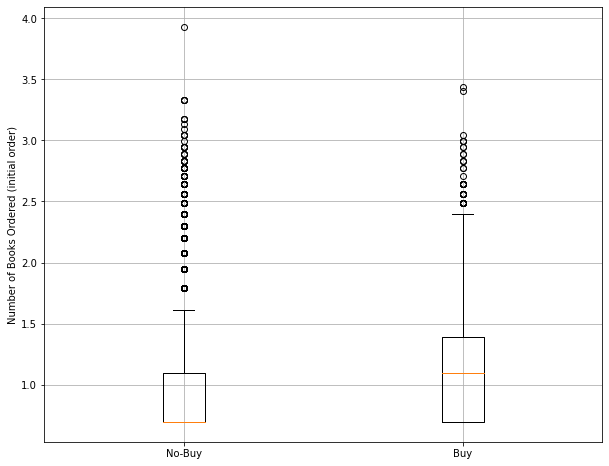

In [28]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
target0 = train[train['target90'] == 0]
target1 = train[train['target90'] == 1]

## Creating side-by-side box plots
plt.boxplot([np.log(target0['numberitems'] + 1), np.log(target1['numberitems'] + 1)], labels = ['No-Buy', 'Buy'])
plt.ylabel('Number of Books Ordered (initial order)')
plt.grid()

## saving the plot
# plt.savefig('side_by_side_boxplot.pdf')

plt.show()

In [3]:
pd.crosstab(train['salutation'], train['target90'])

target90,0,1
salutation,,
0,14391,3449
1,9454,2160
2,2532,442


In [4]:
Z = pd.DataFrame(pd.crosstab(train['domain'], train['target90']))
Z.columns = ['No_Buy', 'Buy']

Z['Row_Tot'] = Z['No_Buy'] + Z['Buy']
Z['Buy_pct'] = Z['Buy'] / Z['Row_Tot']

Z = Z.sort_values(by = 'Buy_pct', ascending = False)
Z

,No_Buy,Buy,Row_Tot,Buy_pct
domain,,,,
8,2951,743,3694,0.201137
6,438,110,548,0.200730
1,912,227,1139,0.199298
5,1062,249,1311,0.189931
12,6273,1461,7734,0.188906
11,1154,268,1422,0.188467
9,5662,1291,6953,0.185675
4,5430,1197,6627,0.180625
7,93,20,113,0.176991


In [123]:
x = train[train['domain'] == 12]
X = pd.DataFrame(pd.crosstab(x['points'], x['target90']))
X.columns = ['No_Buy', 'Buy']

X['Row_Tot'] = X['No_Buy'] + X['Buy']
X['Buy_pct'] = X['Buy'] / X['Row_Tot']

X = X.sort_values(by = 'Buy_pct', ascending = False)
X

,No_Buy,Buy,Row_Tot,Buy_pct
points,,,,
0,6273,1461,7734,0.188906


In [11]:
train.shape

(32428, 38)

In [107]:
train['w10'].value_counts()

0     30489
1      1451
2       288
3       102
4        38
5        20
6        13
7        10
8         3
10        3
9         2
15        2
38        1
13        1
20        1
50        1
27        1
17        1
12        1
Name: w10, dtype: int64

In [112]:
x = train[train['w10'] == 4]
X = pd.DataFrame(pd.crosstab(x['salutation'], x['target90']))
X.columns = ['No_Buy', 'Buy']

X['Row_Tot'] = X['No_Buy'] + X['Buy']
X['Buy_pct'] = X['Buy'] / X['Row_Tot']
X

,No_Buy,Buy,Row_Tot,Buy_pct
salutation,,,,
0,21,7,28,0.250000
1,6,1,7,0.142857
2,3,0,3,0.000000


In [119]:
Y = pd.crosstab(train['newsletter'], train['target90']) 
Y.columns = ['No_Buy', 'Buy']

Y['Row_Tot'] = Y['No_Buy'] + Y['Buy']
Y['Buy_pct'] = Y['Buy'] / Y['Row_Tot']
Y

,No_Buy,Buy,Row_Tot,Buy_pct
newsletter,,,,
0,22300,4632,26932,0.171989
1,4077,1419,5496,0.258188
